# Read wind data

In [ ]:
require(oce, warn.conflicts = FALSE)

In [5]:
library(tidyverse, warn.conflicts = FALSE)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.3     ✔ dplyr   1.0.1
✔ tidyr   1.1.1     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()



In [6]:
library(cowplot, warn.conflicts = FALSE)
library(scales, warn.conflicts = FALSE)

# library to read matlab data formats into R
library(reshape2)
library(lubridate)

# set strings as factors to false
options(stringsAsFactors = FALSE)


********************************************************

Note: As of version 1.0.0, cowplot does not change the

  default ggplot2 theme anymore. To recover the previous

  behavior, execute:
  theme_set(theme_cowplot())

********************************************************



Attaching package: ‘reshape2’


The following object is masked from ‘package:tidyr’:

    smiths



Attaching package: ‘lubridate’


The following object is masked from ‘package:cowplot’:

    stamp


The following objects are masked from ‘package:base’:

    date, intersect, setdiff, union




In [7]:
wind_ds <- read.csv("ERA5_reanalyisis_monthly.csv")

wind_ds$time = parse_date_time(wind_ds$time, orders = "%Y-%m-%d H:M:S")

### add new Date column (month resolution)

In [8]:
wind_ds_monthly <- wind_ds %>%
  mutate(time_month = format(time, format = "%m-%Y"))

In [9]:
str(wind_ds)

'data.frame':	998 obs. of  261 variables:
 $ time      : POSIXct, format: "1978-12-31 18:00:00" "1979-01-01 00:00:00" ...
 $ u100      : num  NA -6.81 NA -9.42 NA ...
 $ v100      : num  NA -3.93 NA -4.43 NA ...
 $ u10n      : num  NA -5.64 NA -7.58 NA ...
 $ u10       : num  NA -5.56 NA -7.51 NA ...
 $ v10n      : num  NA -3.44 NA -3.75 NA ...
 $ v10       : num  NA -3.38 NA -3.72 NA ...
 $ si10      : num  NA 6.88 NA 8.66 NA ...
 $ d2m       : num  NA 295 NA 295 NA ...
 $ t2m       : num  NA 297 NA 298 NA ...
 $ p140209   : num  NA 1.16 NA 1.16 NA ...
 $ anor      : num  NA 0.785 NA 0.785 NA ...
 $ isor      : num  NA 0 NA 0 NA 0 NA 0 NA 0 ...
 $ bfi       : num  NA 0.0758 NA 0.1308 NA ...
 $ bld       : num  136360 NA 202031 NA 131401 ...
 $ blh       : num  NA 518 NA 588 NA ...
 $ chnk      : num  NA 0.0135 NA 0.0178 NA ...
 $ cdir      : num  18786336 NA 20692176 NA 22012240 ...
 $ cbh       : num  1872 NA 3074 NA 3181 ...
 $ cdww      : num  NA 0.000966 NA 0.001087 NA ...
 $ cape

# read NISKIN data (from csv)

other datasets:
- PINTDF_integratedChlorophyll.csv
- MLD2EuZ_2.csv
- biogeochembact_dtypes.csv
- niskin_dtypes.csv


In [10]:
niskin_ds <- read.csv("../VeryNEWESTCariacoData/niskin_dtypes.csv")

#niskin_ds$time = parse_date_time(niskin_ds$time, orders = "%Y-%m-%d H:M:S")

In [11]:
str(niskin_ds)

'data.frame':	4394 obs. of  97 variables:
 $ unlimited                  : int  0 1 2 3 4 5 6 7 8 9 ...
 $ Cruise_number              : int  1 1 1 1 1 1 1 1 1 1 ...
 $ Cruise_ID_1                : chr  "93HG_001" "93HG_001" "93HG_001" "93HG_001" ...
 $ Cruise_ID_2                : chr  "CAR-001" "CAR-001" "CAR-001" "CAR-001" ...
 $ Leg                        : int  2 2 2 2 2 2 2 2 2 2 ...
 $ Day                        : int  8 8 8 8 8 8 8 8 8 8 ...
 $ Month                      : int  11 11 11 11 11 11 11 11 11 11 ...
 $ Year                       : int  1995 1995 1995 1995 1995 1995 1995 1995 1995 1995 ...
 $ Latitude                   : num  10.5 10.5 10.5 10.5 10.5 10.5 10.5 10.5 10.5 10.5 ...
 $ Longitude                  : num  -64.7 -64.7 -64.7 -64.7 -64.7 ...
 $ Hydro_cast_no              : num  1 1 1 1 1 1 1 1 3 3 ...
 $ Depth_target               : num  1 7 15 25 35 55 75 100 150 200 ...
 $ Depth_real                 : num  1.5 6.5 15 25 35 ...
 $ O2_ml_L                    : n

# interpolate niskin_ds

In [12]:
niskin_ds$DATE <- paste(niskin_ds$Year,'-',niskin_ds$Month,'-',niskin_ds$Day, sep='')

In [13]:
# Function to read specific verfication type from dataset

prepdataframe <- function(variable='', datasource='niskin'){
    if(datasource=='niskin'){
    DF <- niskin_ds
    DF$date <- as.Date(DF$DATE, format="%Y-%m-%d")
    DF$depth <- DF$Depth_real
    #print(names(DF))
        
    VarDF <- DF %>%
      select(date, variable, depth) %>%
      gather(key='key',value = "value", -date, -depth)
    #head(VarDF)
    }
    
    return(VarDF)
}

In [14]:
# Interpolate
interpolateDF <- function(DF,func='oce-rr'){
    zz <- seq(0, 200, 1)
    
    if(func=='linear'){
        IntDF <- DF %>%
            group_by(date) %>%
            filter(sum(!is.na(value))>1) %>%
            do(data.frame(value_int = with(.,approx(depth, value, zz)), depth = zz)) 
        
        IntDF <- IntDF %>% 
              rename(
                value_int = value_int.y
                )
        IntDF$value_int.x <- NULL
        }
    
    else if(func=='oce-rr'){
        IntDF <- DF %>%
            group_by(date) %>%
            do(data.frame(value_int = with(.,oceApprox(depth, value, zz, "rr")), depth = zz)) 
        }
    
    return(IntDF)
}

In [65]:
# wind_ds_monthly

In [178]:
interpolateNiskin <- function(var){
 
    niskin_dat <- prepdataframe(var)

    niskin_int <- interpolateDF(niskin_dat, 'linear')   
    
    niskin_sum <- niskin_int %>%
        group_by(date) %>%
        filter(depth<101) %>%
        filter(sum(is.na(value_int))<20) %>%
        summarize(value_sum = sum(value_int, na.rm=TRUE), 
                  var = mean(value_int, na.rm=TRUE),
                  #value_intgrtd = value_mean * 100,
                  NAs = sum(is.na(value_int)), .groups="keep")
    
    niskin_sum_monthly <- niskin_sum %>%
          mutate(time_month = format(date, format="%m-%Y"))

    
    return(niskin_sum_monthly)
}

In [240]:
getWindData <- function(windvar){
    
    wind_ds_var <- wind_ds_monthly %>%
          select(time_month, windvar)
    
    return(na.omit(wind_ds_var))
}

In [163]:
interpolatedmerge <- function(var, windvar){
 
    niskin_dat <- prepdataframe(var)

    niskin_int <- interpolateDF(niskin_dat, 'linear')   
    
    niskin_sum <- niskin_int %>%
        group_by(date) %>%
        filter(depth<101) %>%
        filter(sum(is.na(value_int))<20) %>%
        summarize(value_sum = sum(value_int, na.rm=TRUE), 
                  value_mean = mean(value_int, na.rm=TRUE),
                  value_intgrtd = value_mean * 100,
                  NAs = sum(is.na(value_int)), .groups="keep")
    
    niskin_sum_monthly <- niskin_sum %>%
          mutate(time_month = format(date, format="%m-%Y"))
    
    wind_ds_var <- wind_ds_monthly %>%
          select(time_month, windvar)
    
    wind_niskin <- merge(wind_ds_var, niskin_sum_monthly, all=TRUE)
    
    wind_niskin$time <- parse_date_time(wind_niskin$time_month, orders="%m-%Y")
    
    wind_niskin_addyear <- wind_niskin %>%
        mutate(year = format(date, format="%Y")) %>%
        group_by(year) %>%
        mutate(value_yearly_mean = mean(value_intgrtd, na.rm=TRUE))

    
    return(wind_niskin_addyear)
}

In [17]:
# str(niskin_ds)

In [18]:
options(repr.plot.width=15, repr.plot.height=7)

`geom_smooth()` using method = 'loess' and formula 'y ~ x'

Warning message:
“Removed 500 rows containing non-finite values (stat_smooth).”
Warning message:
“Removed 500 rows containing missing values (geom_point).”


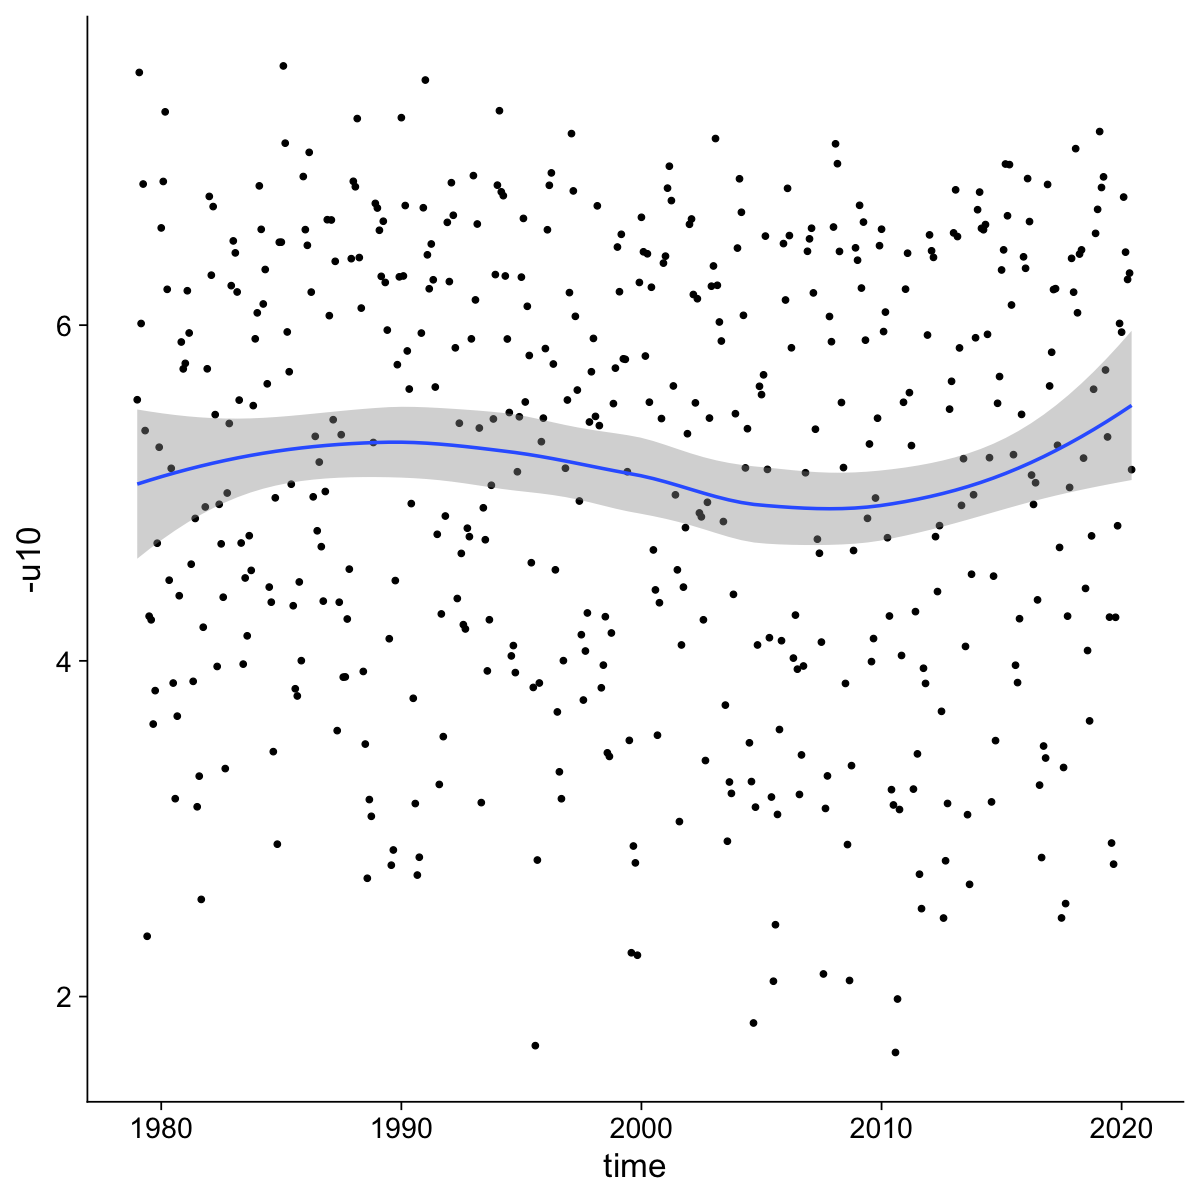

In [25]:
ggplot(data=wind_ds,aes(x=time, y=-u10)) + geom_point() + 
#geom_smooth(method='lm') + 
geom_smooth()+
    theme_cowplot(font_size = 20)

Warning message:
“Removed 796 rows containing missing values (geom_point).”
Warning message:
“Removed 960 rows containing missing values (geom_point).”


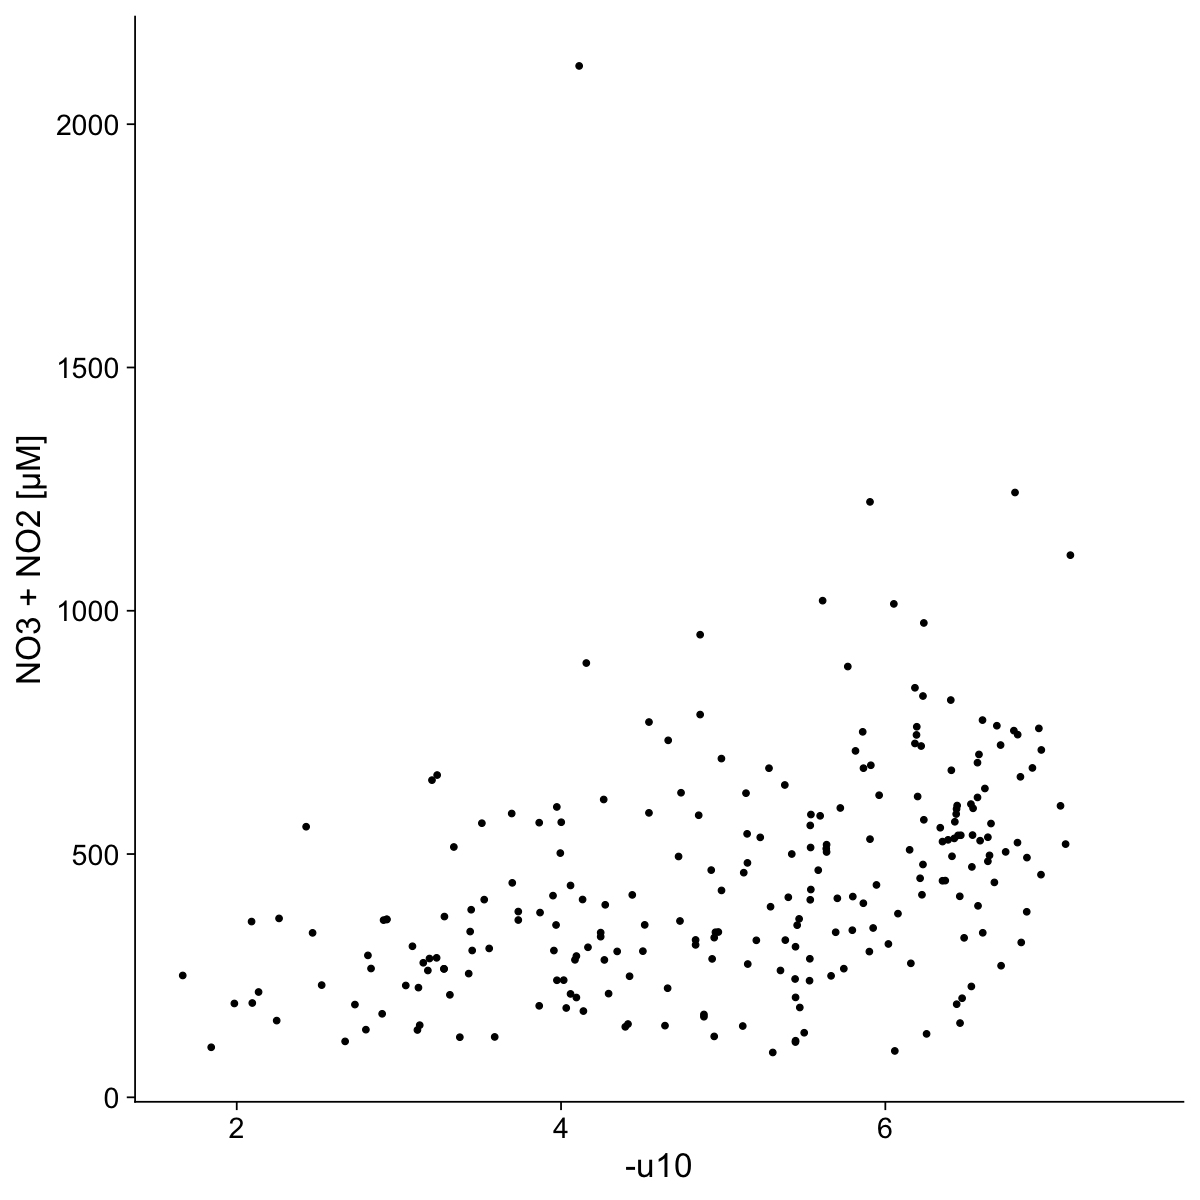

In [26]:
options(repr.plot.width=10, repr.plot.height=10)

niskin_wind_NO3_NO2_USF = interpolatedmerge('NO3_NO2_USF', 'u10')
niskin_wind_NO3_UDO = interpolatedmerge('NO3_UDO', 'u10')

ggplot(data=niskin_wind_NO3_NO2_USF, aes(y=value_intgrtd, x=-u10)) + geom_point() + 
    geom_point(data=niskin_wind_NO3_UDO, aes(y=value_intgrtd, x=-u10)) +
    theme_cowplot(font_size = 20) + ylab('NO3 + NO2 [µM]')

Warning message:
“Removed 771 rows containing missing values (geom_point).”
Warning message:
“Removed 771 rows containing missing values (geom_point).”


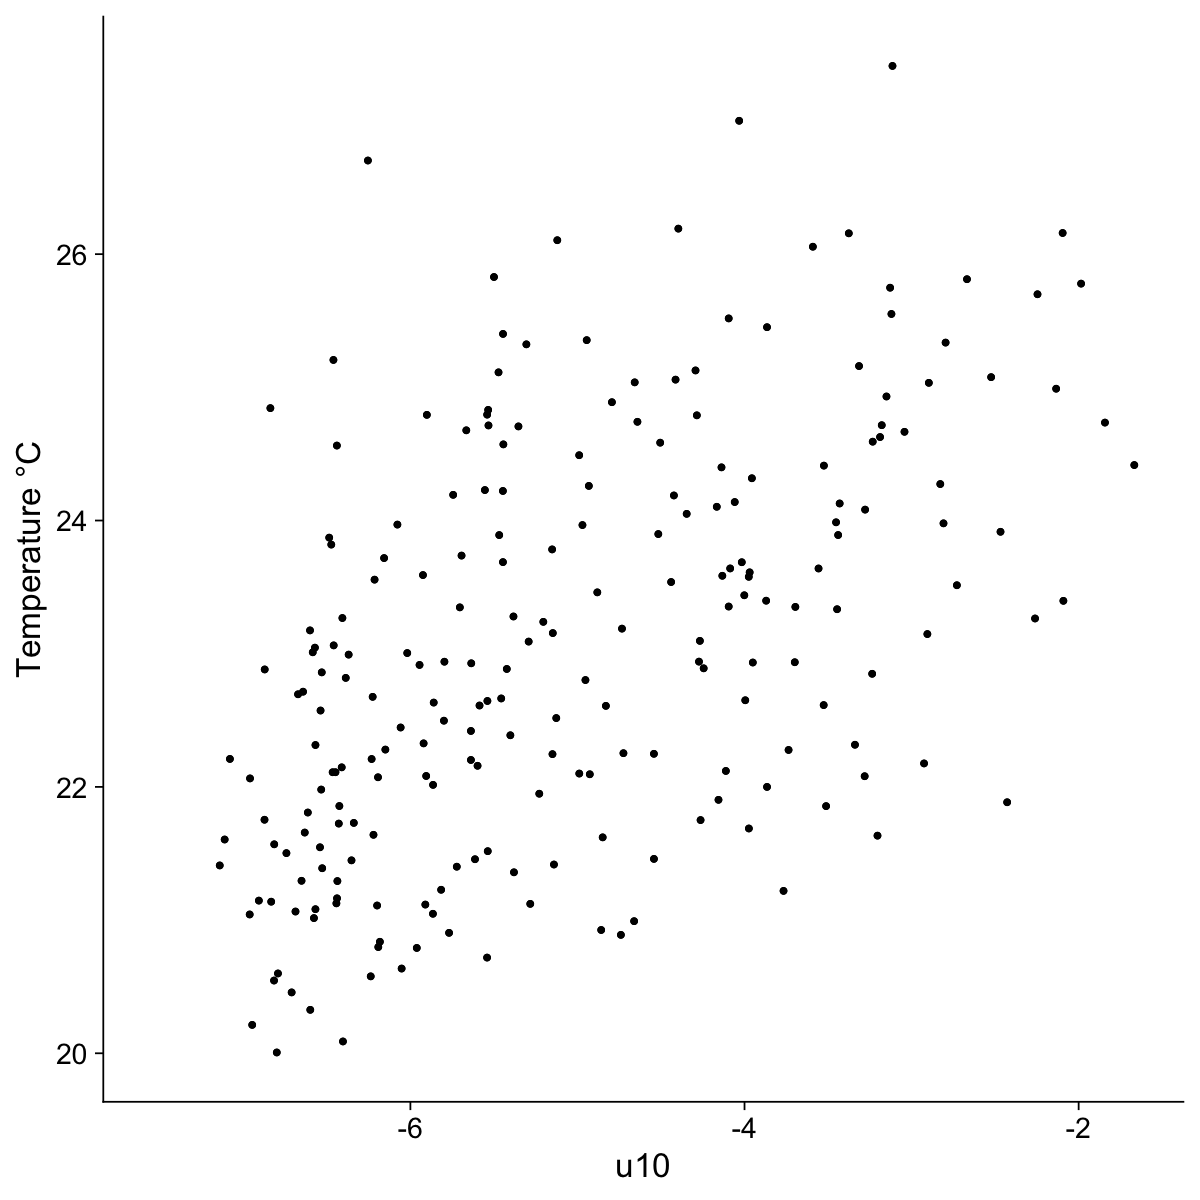

In [28]:
niskin_wind_Temperature = interpolatedmerge('Temperature', 'u10')

ggplot(data=niskin_wind_Temperature, aes(y=value_mean, x=u10)) + geom_point() + 
    geom_point(data=niskin_wind_Temperature, aes(y=value_mean, x=u10)) +
    theme_cowplot(font_size = 20) + ylab('Temperature °C')

# check why outliers?

Warning message:
“Removed 771 rows containing missing values (geom_point).”
Warning message:
“Removed 771 rows containing missing values (geom_point).”


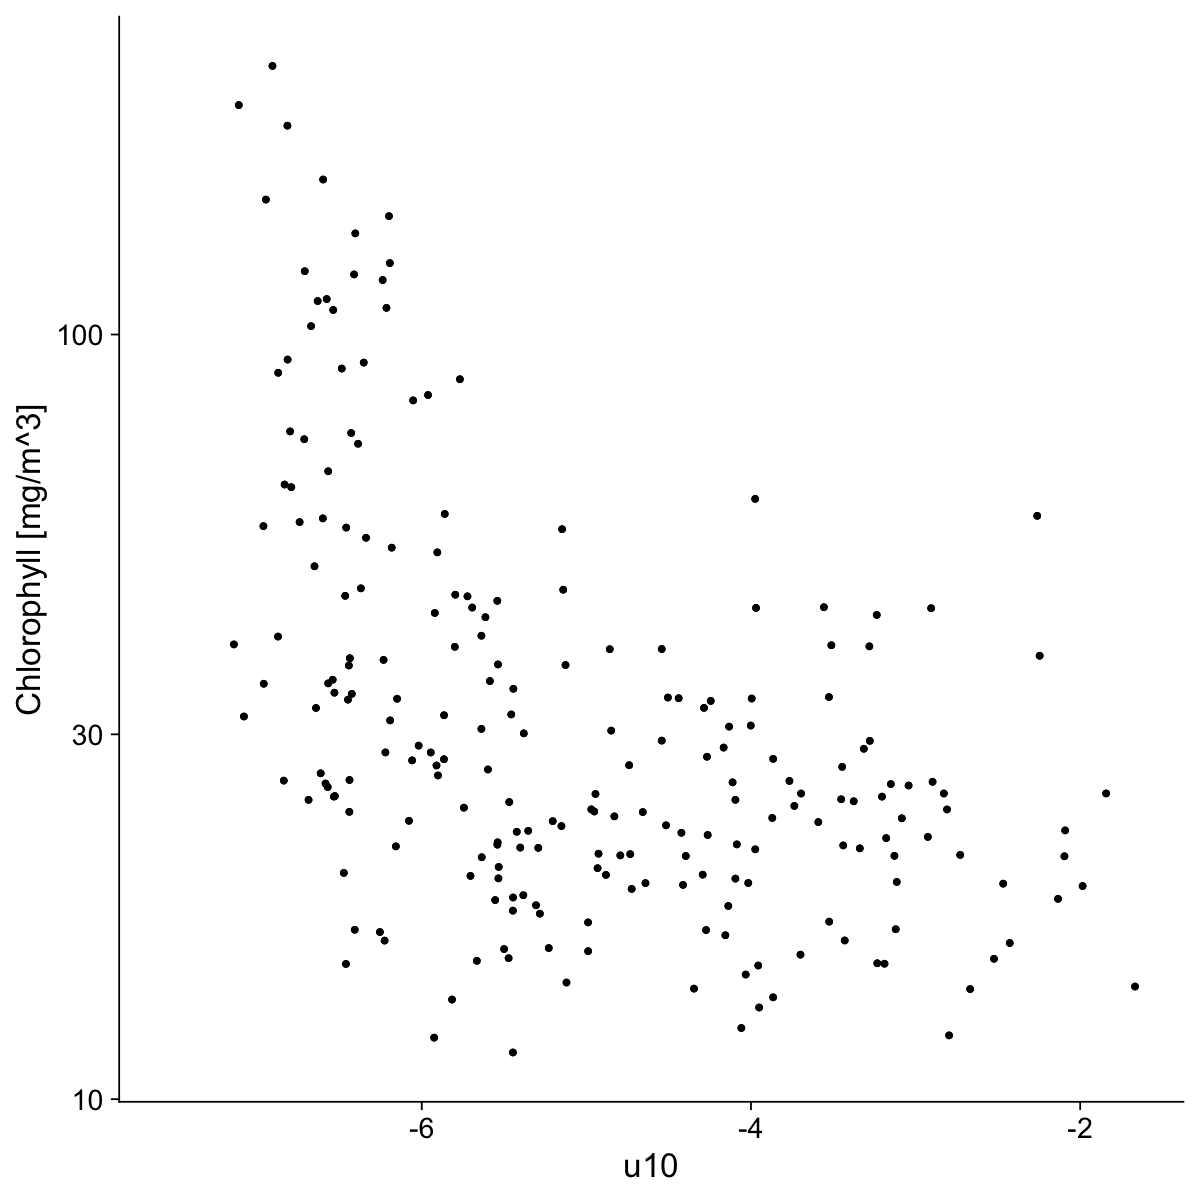

In [29]:
niskin_wind_Chlorophyll = interpolatedmerge('Chlorophyll', 'u10')

ggplot(data=niskin_wind_Chlorophyll, aes(y=value_intgrtd, x=u10)) + geom_point() + 
    geom_point(data=niskin_wind_Chlorophyll, aes(y=value_intgrtd, x=u10)) +
    theme_cowplot(font_size = 20) + ylab('Chlorophyll [mg/m^3]') + scale_y_log10()

Warning message:
“Removed 796 rows containing missing values (geom_point).”


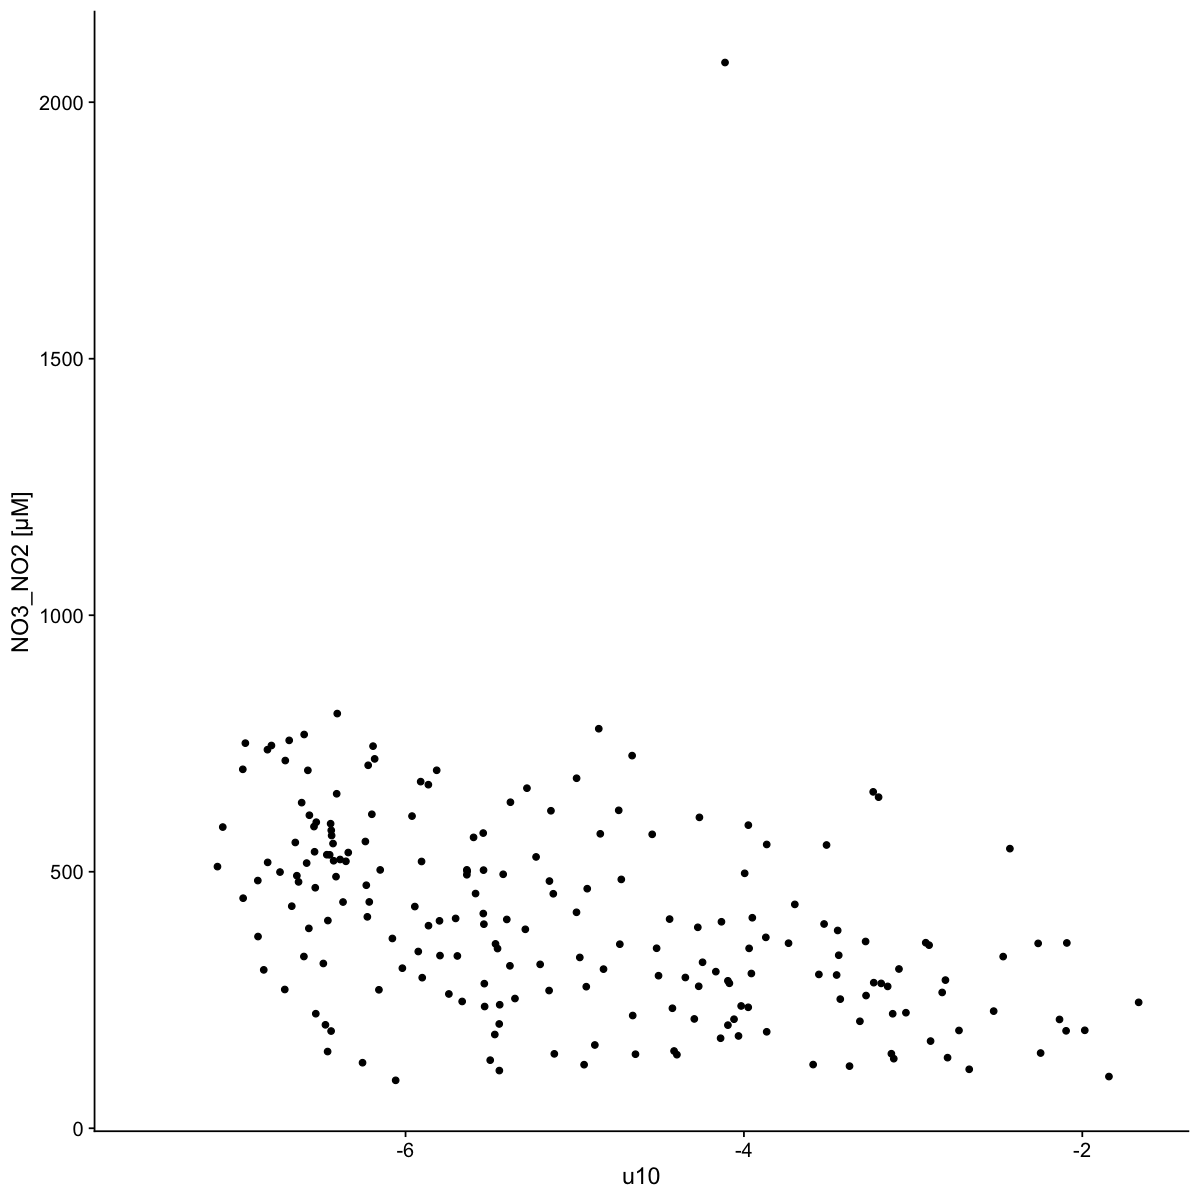

In [30]:
niskin_wind_NO3_NO2_USF = interpolatedmerge('NO3_NO2_USF', 'u10')

ggplot(data=niskin_wind_NO3_NO2_USF) + geom_point(aes(y=value_sum ,x=u10)) + 
theme_cowplot() + ylab('NO3_NO2 [µM]')

In [31]:
niskin_NO3_NO2_USF

ERROR: Error in eval(expr, envir, enclos): object 'niskin_NO3_NO2_USF' not found


## merge nisking to wind!

In [170]:
niskin_numeric = c('O2_ml_L',
                'O2_umol_kg',  
                'NO3_UDO',
                'PO4_UDO',
                'SiO4_UDO',
                'NH4_USF',
                'NO2_USF',
                'NO3_NO2_USF',
                'PO4_USF',
                'SiO4_USF',
                'pH',
                'Alkalinity_mol_kg',
                'Alkalinity_umol_kg',
                'TCO2',
                'fCO2',
                'pH_corrected',
                'TCO2_corrected',
                'fCO2_corrected',
                'Salinity_bottles',
                'Salinity_CTD',
                'Temperature',
                'Sigma_t',
                'TPP',
                'PIP',
                'POC_ug_kg',
                'PON_ug_kg',
                'POC_ug_L',
                'PN_ug_L',
                'C_N_particulate',
                'DON',
                'DOP',
                'DOC',
                'TOC',
                'PrimaryProductivity',
                'Chlorophyll',
                'Phaeopigments',
                'Total_Prokaryotes',
                'Bact_Biomass_mgC_m3',
                'Bact_Biomass_uMC')

In [212]:
#XXX <- interpolateNiskin('NO3_NO2_USF')

niskin_temp_store = list()

In [226]:
for (variable in niskin_numeric) {
    print(variable)
    dat <- interpolateNiskin(variable)
    niskin_temp_store[[variable]] <- data.frame(dat_var = dat$var, time_month = dat$time_month)
    names(niskin_temp_store[[variable]])[1] <- variable
    #print(head(niskin_temp_store[[variable]]))
}

[1] "O2_ml_L"
[1] "O2_umol_kg"
[1] "NO3_UDO"
[1] "PO4_UDO"
[1] "SiO4_UDO"
[1] "NH4_USF"
[1] "NO2_USF"
[1] "NO3_NO2_USF"
[1] "PO4_USF"
[1] "SiO4_USF"
[1] "pH"
[1] "Alkalinity_mol_kg"
[1] "Alkalinity_umol_kg"
[1] "TCO2"
[1] "fCO2"
[1] "pH_corrected"
[1] "TCO2_corrected"
[1] "fCO2_corrected"
[1] "Salinity_bottles"
[1] "Salinity_CTD"
[1] "Temperature"
[1] "Sigma_t"
[1] "TPP"
[1] "PIP"
[1] "POC_ug_kg"
[1] "PON_ug_kg"
[1] "POC_ug_L"
[1] "PN_ug_L"
[1] "C_N_particulate"
[1] "DON"
[1] "DOP"
[1] "DOC"
[1] "TOC"
[1] "PrimaryProductivity"
[1] "Chlorophyll"
[1] "Phaeopigments"
[1] "Total_Prokaryotes"
[1] "Bact_Biomass_mgC_m3"
[1] "Bact_Biomass_uMC"


In [227]:
#print(head(niskin_temp_store[4]))

In [228]:
niskin_intrp <- niskin_temp_store %>% 
    reduce(left_join, by = "time_month")

In [229]:
head(niskin_intrp)

,Bact_Biomass_uMC,time_month,O2_ml_L,O2_umol_kg,NO3_UDO,PO4_UDO,SiO4_UDO,NH4_USF,NO2_USF,NO3_NO2_USF,⋯,C_N_particulate,DON,DOP,DOC,TOC,PrimaryProductivity,Chlorophyll,Phaeopigments,Total_Prokaryotes,Bact_Biomass_mgC_m3
,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,0.1776498,12-1995,3.438551,149.8085,3.094884,0.2114269,3.868919,NA,NA,NA,⋯,8.822474,NA,NA,NA,NA,0.4826918,0.1150949,0.1636278,0.7002847,2.131909
2,0.8274119,01-1996,3.405264,148.3119,7.511627,0.3038380,4.868135,NA,NA,NA,⋯,14.128688,NA,NA,81.52567,NA,2.0569311,0.5825762,0.3451711,3.0429052,9.928947
3,0.7046181,02-1996,3.304298,143.9005,6.877783,0.3254108,4.052312,NA,NA,NA,⋯,17.348920,NA,NA,70.76477,NA,1.2175528,0.3497634,0.2855399,2.5915307,8.455257
4,0.4609772,04-1996,3.569975,155.4296,6.770011,0.3604213,3.744388,NA,NA,NA,⋯,23.713121,NA,NA,89.78809,NA,0.9200121,2.2452814,1.3622393,1.6907867,5.531503
5,1.1467797,05-1996,3.011871,131.1264,8.853604,0.4104442,4.817140,NA,NA,NA,⋯,10.642783,NA,NA,NA,NA,5.4573471,0.8740617,0.4288778,4.2037764,13.761397
6,1.3837328,06-1996,3.631876,158.1693,7.712745,0.2832442,3.655185,NA,NA,NA,⋯,19.997651,NA,NA,81.29121,NA,1.0564614,0.2943889,0.2438052,5.0894137,16.604926


In [ ]:
getWindData("u10")

# MERGEEEEEEEEE

In [302]:
# here
ds_wind_niskin <- merge(getWindData("u10"), niskin_intrp, all=TRUE)

ds_wind_niskin$u10 <- -ds_wind_niskin$u10

In [303]:
niskinVSu10 <- cor(ds_wind_niskin[,-1], method = "pearson", use="pairwise.complete.obs")[1,]

In [304]:
names(niskinVSu10_df)[0]

character(0)

In [305]:
niskinVSu10_df <- as.data.frame(niskinVSu10, keep.rownames = TRUE)

names(niskinVSu10_df)[1] <- "correlation"

niskinVSu10_df <- tibble::rownames_to_column(niskinVSu10_df, "var")


In [306]:
str(niskinVSu10_df)
head(niskinVSu10_df)

'data.frame':	40 obs. of  2 variables:
 $ var        : chr  "u10" "Bact_Biomass_uMC" "O2_ml_L" "O2_umol_kg" ...
 $ correlation: num  1 -0.027 -0.325 -0.326 0.573 ...


,var,correlation
,<chr>,<dbl>
1,u10,1.00000000
2,Bact_Biomass_uMC,-0.02696158
3,O2_ml_L,-0.32465169
4,O2_umol_kg,-0.32649095
5,NO3_UDO,0.57288481
6,PO4_UDO,0.44404999


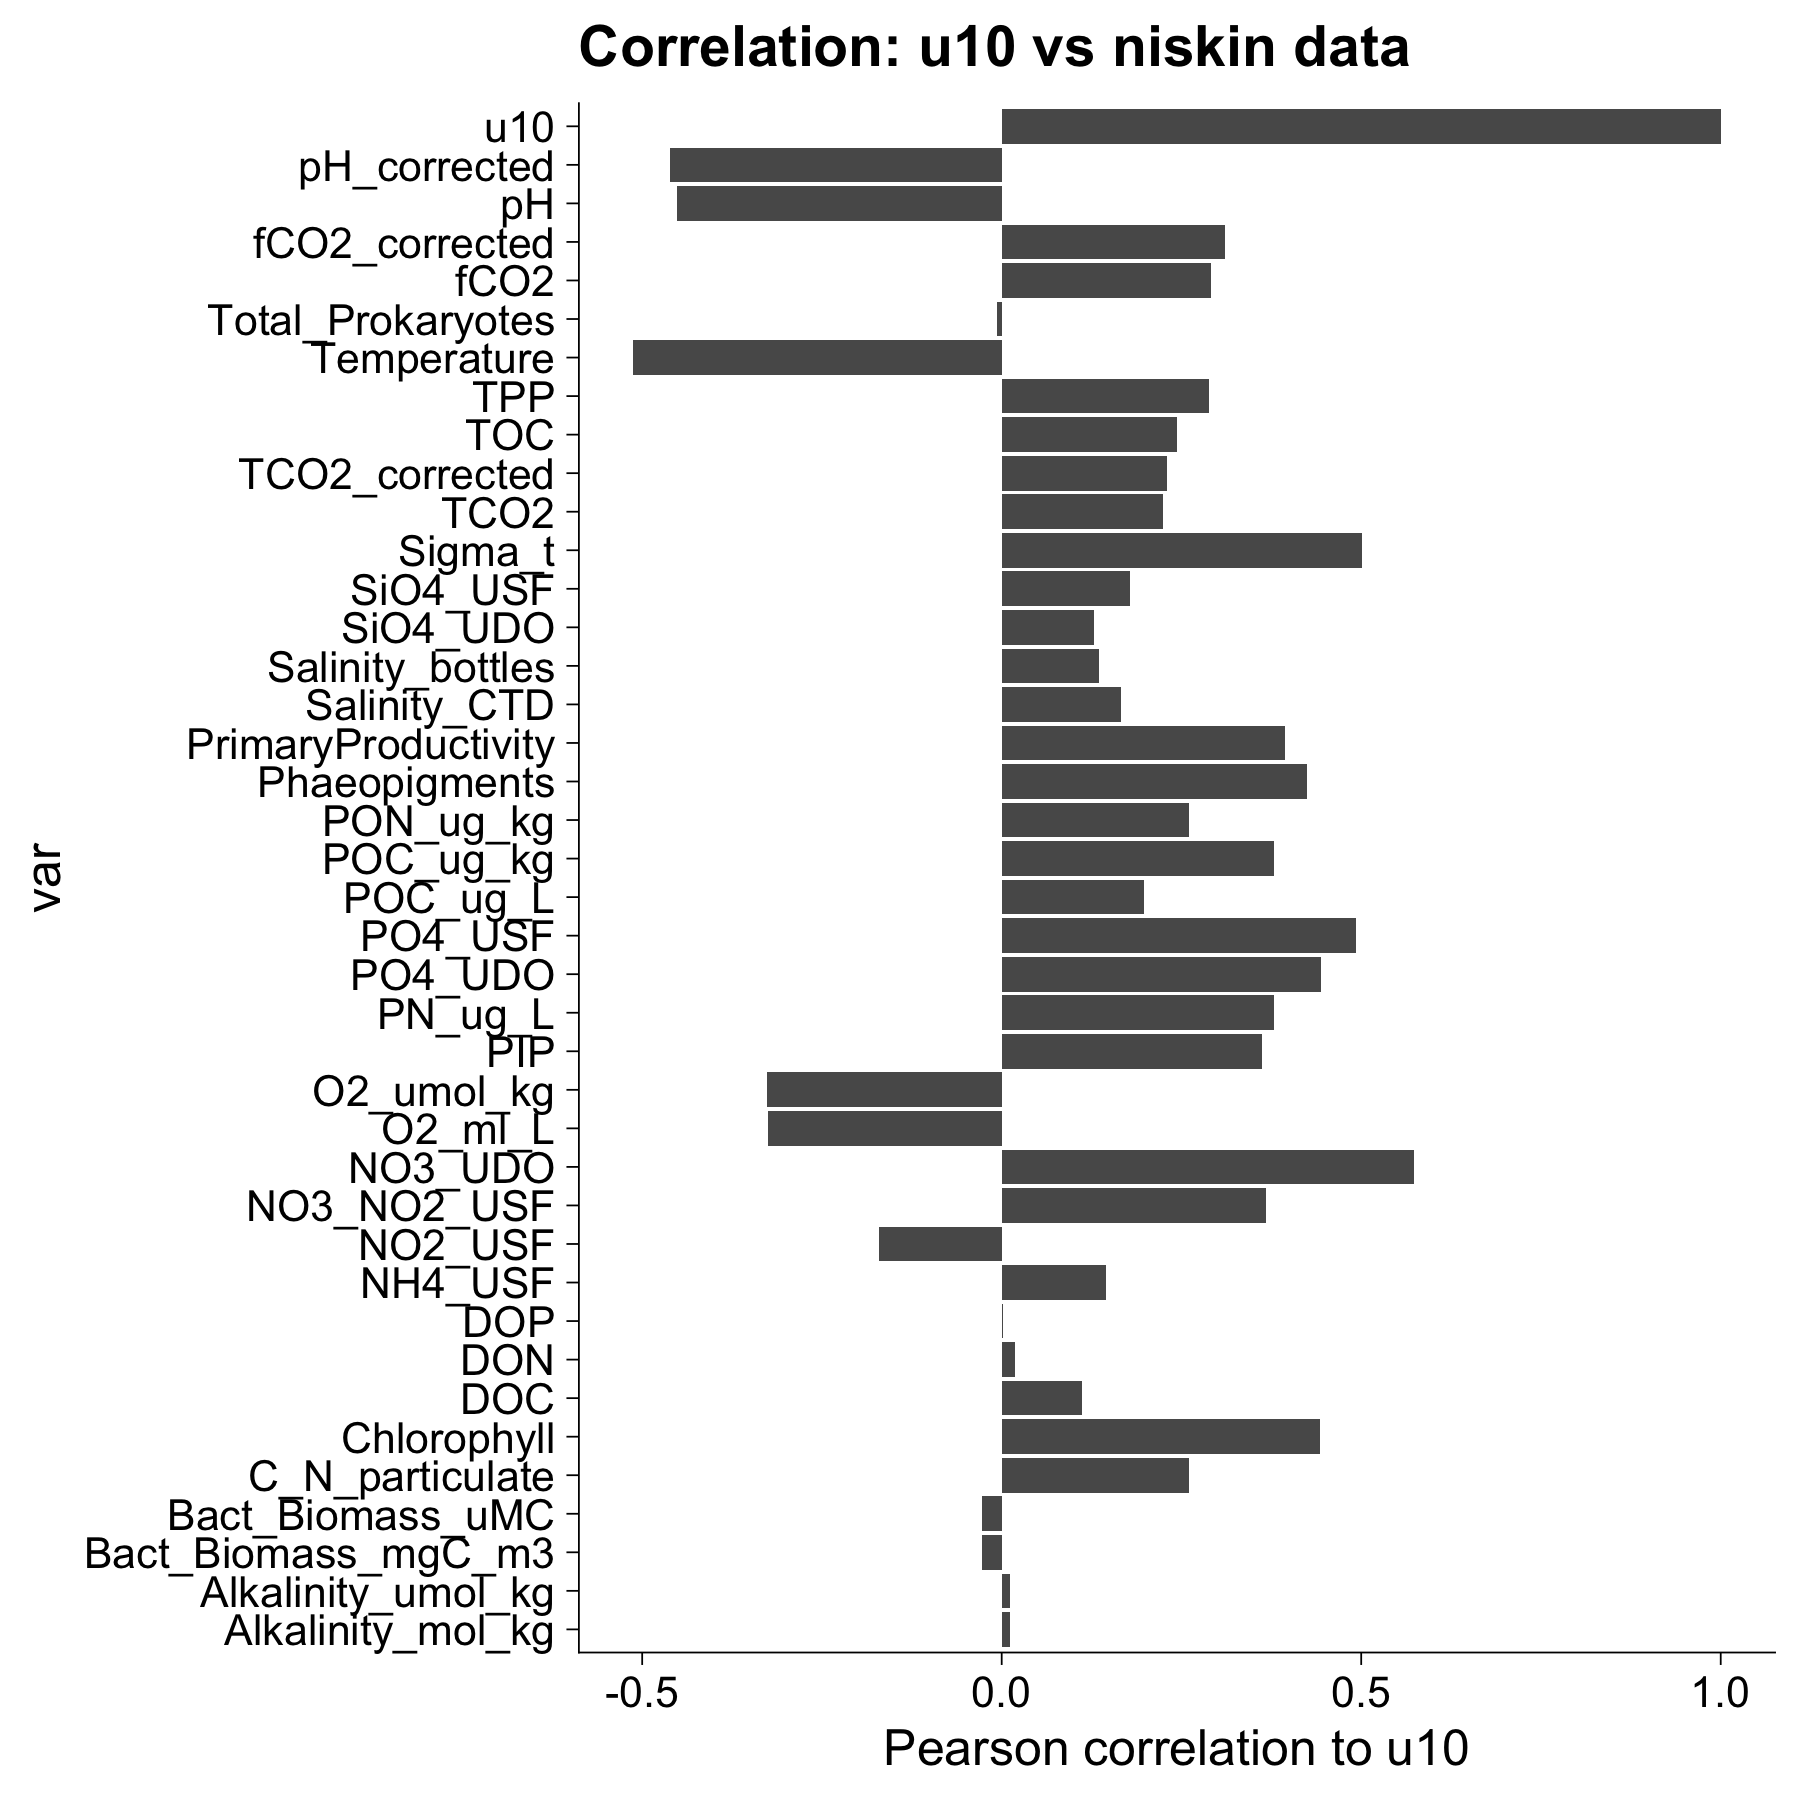

In [310]:
options(repr.plot.width=15, repr.plot.height=15)

ggplot(data=niskinVSu10_df, aes(x=var, y=correlation)) + 
    geom_bar(stat="identity") + ylab("Pearson correlation to u10") +
    theme_cowplot(font_size=30) + coord_flip() + ggtitle("Correlation: u10 vs niskin data")

In [311]:
ggsave('u10vsNiskin_correlation_plot.pdf', width=15, height=15)

In [43]:
ds <- read.csv("../VeryNEWESTCariacoData/phytoplankton.csv")

ds$Datetime_UTC = parse_date_time(ds$Datetime_UTC, orders = "%Y-%m-%d H:M:S")
ds$Datetime_local = parse_date_time(ds$Datetime_local, orders = "%Y-%m-%d H:M:S")

ds$date = ds$Datetime_UTC

## now read Functional Group annotated csv

In [44]:
annotated_fg <- read.csv("worms_dat_annotated_OLDFUNCGROUP.csv", sep=";", dec=',', stringsAsFactor=FALSE)
#annotated_fg = annotated_fg[complete.cases(annotated_fg),]

# trim dataframe to relevant columns
AphiaID2FG <- data.frame("AphiaID" = annotated_fg$AphiaID, 
                         "FuncGroup"=as.character(annotated_fg$functionalgroup_old), 
                         stringsAsFactors=FALSE)

## and merge with ds by AphiaID

In [45]:
ds_FG <- merge(ds, AphiaID2FG, all=TRUE)

In [46]:
ds_FG$FuncGroup[ds_FG$ScientificName_accepted == "nanoflagellates"]   <- "NANOFLAGELLATES"
ds_FG$FuncGroup[ds_FG$ScientificName_accepted == "palmelloid colony"] <- "PALMELLOIDCOLONY"

In [49]:
# ds_FG$date

# Now let's plot some raw counts:

Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message:
“Removed 1 rows containing missing values (geom_point).”


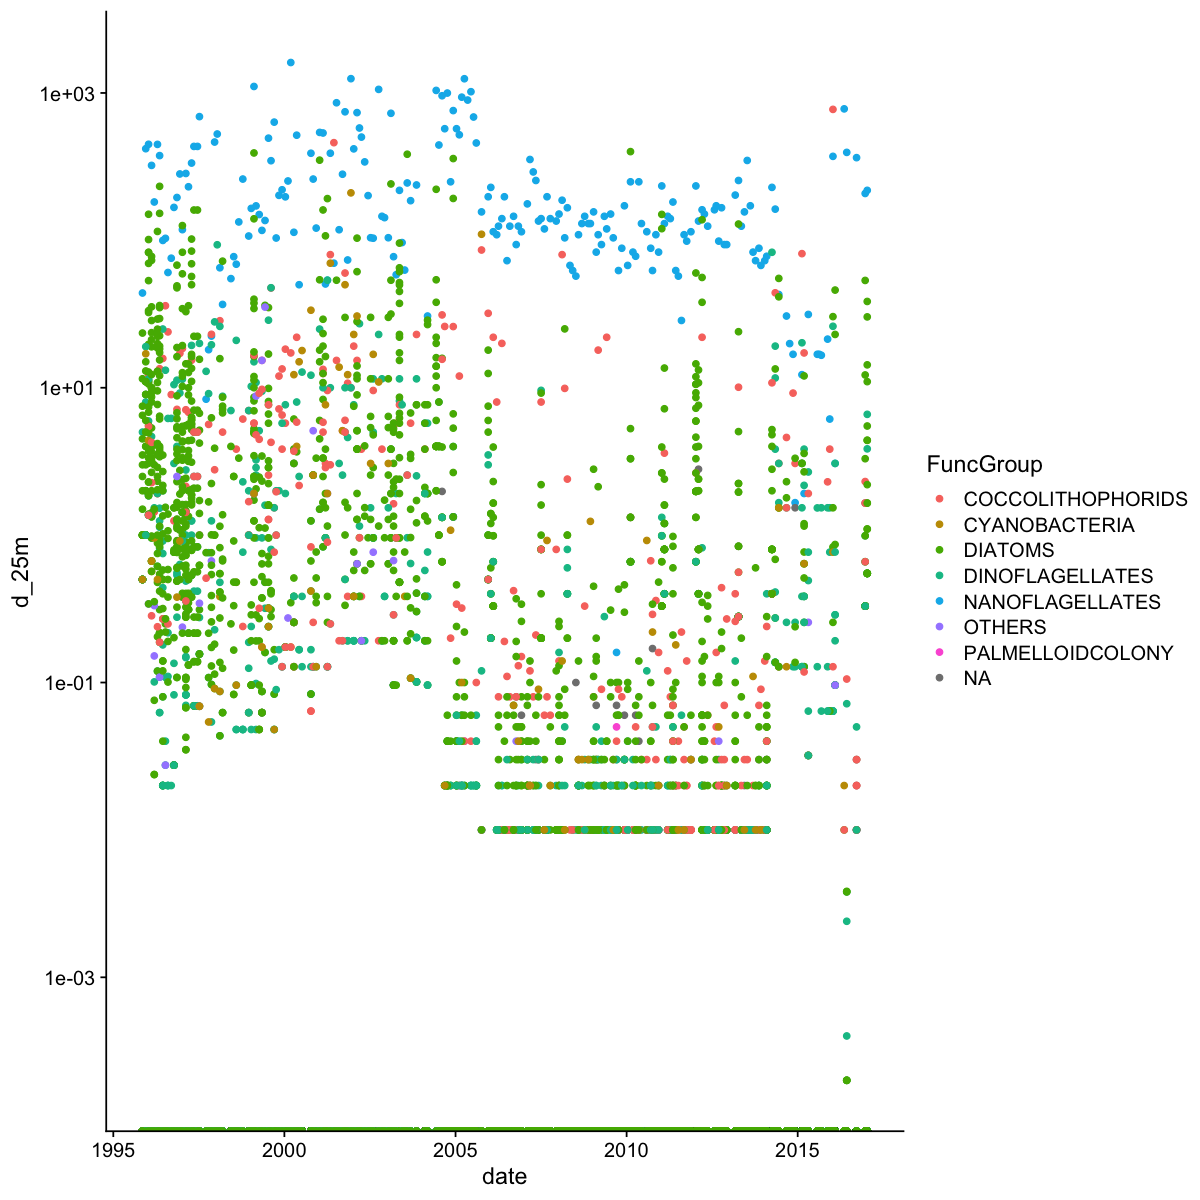

In [51]:
ggplot(data=ds_FG, aes(x=date, y=d_25m, color=FuncGroup)) + 
    geom_point() + theme_cowplot() + scale_y_log10()

In [61]:
head(ds_FG$AphiaID)
head(ds_FG$date)
head(ds_FG$d_1m)
head(ds_FG$FuncGroup)

[1] -9.223372e+18 -9.223372e+18 -9.223372e+18 -9.223372e+18 -9.223372e+18
[6] -9.223372e+18

[1] "2017-01-12 08:17:00 UTC" "1996-02-13 08:16:00 UTC"
[3] "2002-07-09 10:00:00 UTC" "2002-07-09 10:00:00 UTC"
[5] "2002-07-09 10:00:00 UTC" "2004-11-09 08:31:00 UTC"

[1]   0.0   0.0   0.0   0.0   0.0 124.8

[1] NA                 "PALMELLOIDCOLONY" NA                 NA                
[5] NA                 "NANOFLAGELLATES"

In [63]:
ds <- ds_FG

blob <- rbind(data.frame(val=ds$d_1m, depth=1, date=ds$date, AphiaID=ds$AphiaID, FuncGroup=ds$FuncGroup),
      data.frame(val=ds$d_7m, depth=7, date=ds$date, AphiaID=ds$AphiaID, FuncGroup=ds$FuncGroup),
      data.frame(val=ds$d_15m, depth=15, date=ds$date, AphiaID=ds$AphiaID, FuncGroup=ds$FuncGroup),
      data.frame(val=ds$d_25m, depth=25, date=ds$date, AphiaID=ds$AphiaID, FuncGroup=ds$FuncGroup),
      data.frame(val=ds$d_55m, depth=55, date=ds$date, AphiaID=ds$AphiaID, FuncGroup=ds$FuncGroup),
      data.frame(val=ds$d_75m, depth=75, date=ds$date, AphiaID=ds$AphiaID, FuncGroup=ds$FuncGroup),
      data.frame(val=ds$d_100m, depth=100, date=ds$date, AphiaID=ds$AphiaID, FuncGroup=ds$FuncGroup))

In [66]:
head(blob)

,val,depth,date,AphiaID,FuncGroup
,<dbl>,<dbl>,<dttm>,<dbl>,<chr>
1,0.0,1,2017-01-12 08:17:00,-9.223372e+18,NA
2,0.0,1,1996-02-13 08:16:00,-9.223372e+18,PALMELLOIDCOLONY
3,0.0,1,2002-07-09 10:00:00,-9.223372e+18,NA
4,0.0,1,2002-07-09 10:00:00,-9.223372e+18,NA
5,0.0,1,2002-07-09 10:00:00,-9.223372e+18,NA
6,124.8,1,2004-11-09 08:31:00,-9.223372e+18,NANOFLAGELLATES


In [109]:
blob_sum <- blob %>%
group_by(date, depth, FuncGroup) %>%
summarise(sum_val = sum(val, na.rm=T), depth=mean(depth)) #%>%

head(blob_sum)

`summarise()` regrouping output by 'date', 'depth' (override with `.groups` argument)



date,depth,FuncGroup,sum_val
<dttm>,<dbl>,<chr>,<dbl>
1995-11-08 07:36:00,1,COCCOLITHOPHORIDS,0.000
1995-11-08 07:36:00,1,CYANOBACTERIA,0.000
1995-11-08 07:36:00,1,DIATOMS,59.000
1995-11-08 07:36:00,1,DINOFLAGELLATES,8.500
1995-11-08 07:36:00,1,NANOFLAGELLATES,113.168
1995-11-08 07:36:00,1,OTHERS,0.000


In [110]:
zz <- seq(0, 100, 1)

In [124]:
blobs_interpolated <- blob_sum %>%
group_by(FuncGroup,date) %>%
filter(sum(!is.na(sum_val))>1) %>%
do(data.frame(sum_val_int = with(.,approx(depth, sum_val, zz)), depth = zz)) %>%
summarize(mean_val = mean(sum_val_int.y, na.rm=T))

`summarise()` regrouping output by 'FuncGroup' (override with `.groups` argument)



Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message:
“Removed 1 rows containing missing values (geom_point).”


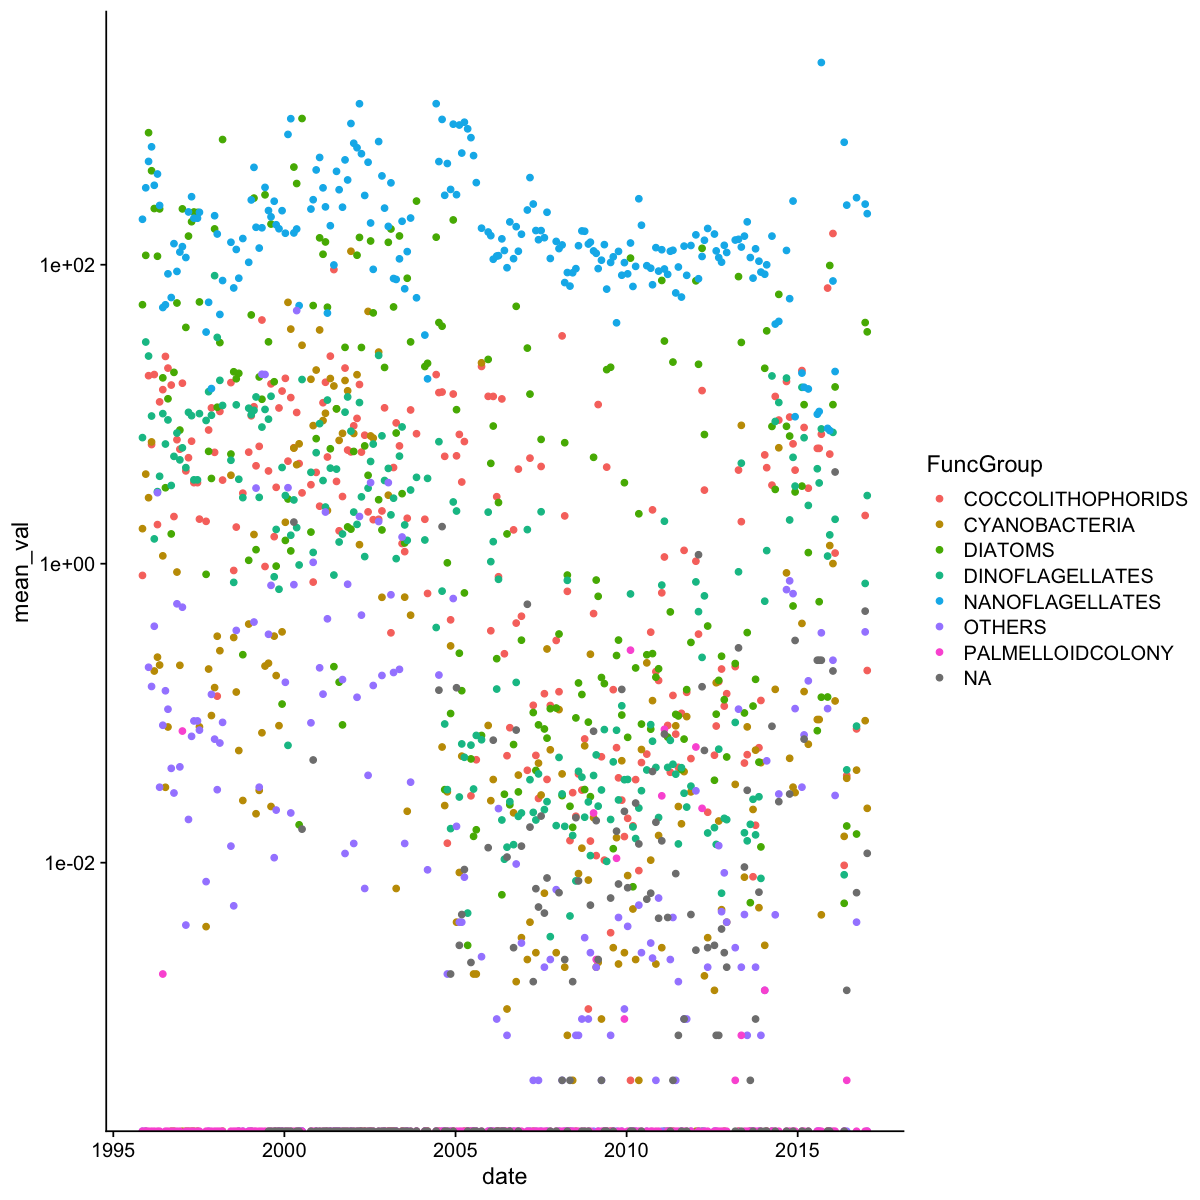

In [125]:
ggplot(data=blobs_interpolated, aes(x=date, y=mean_val, color=FuncGroup)) + 
    geom_point() + theme_cowplot() + scale_y_log10()

In [140]:
options(repr.plot.width=15, repr.plot.height=35)

Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message:
“Removed 435 rows containing non-finite values (stat_boxplot).”


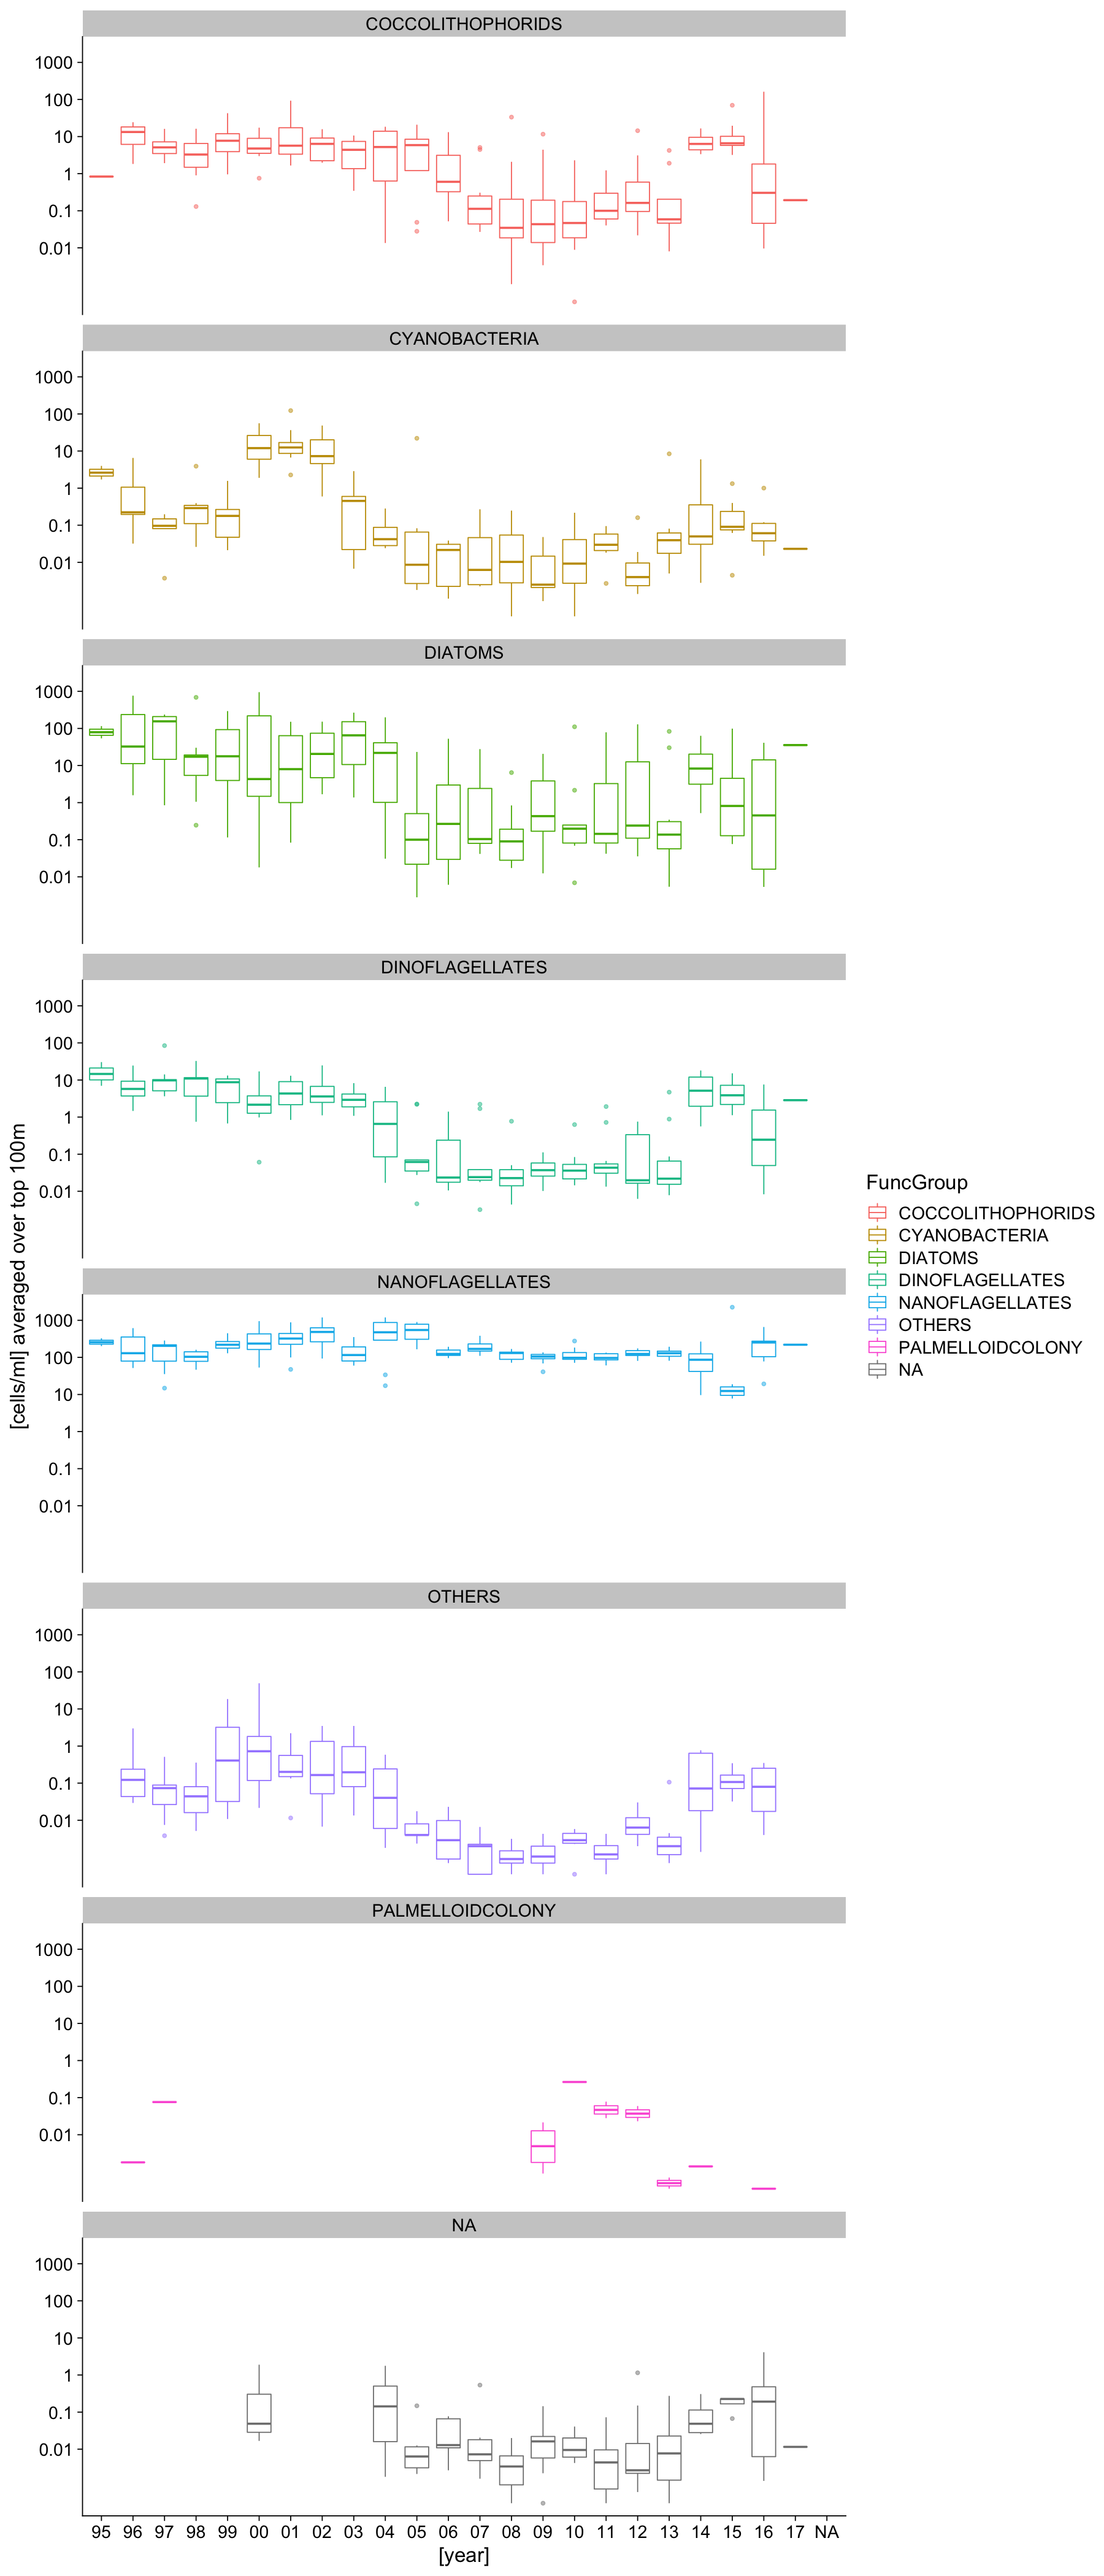

In [152]:
ggplot() +
    #geom_point(data=blobs_interpolated, aes(x=date, y=mean_val, color=FuncGroup))+
    geom_boxplot(data=blobs_interpolated,
             aes(x=reorder(format(blobs_interpolated$date,'%y'),
                           blobs_interpolated$date), y=mean_val, color=FuncGroup), alpha=0.5) +
    theme_cowplot(font_size=20) + scale_y_log10(labels=c(.01,.1,1,10,100,1000),breaks=c(.01,.1,1,10,100,1000))+
    facet_wrap(~FuncGroup, ncol=1)+
    ylab("[cells/ml] averaged over top 100m")+
    xlab("[year]")

In [154]:
ggsave('FuncGroup_plot.pdf', width=15, height=35)

Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message:
“Removed 435 rows containing non-finite values (stat_boxplot).”


# MERGEEEEEEEEE

In [314]:
# here
ds_wind_blobs <- merge(getWindData("u10"), blobs_interpolated[blobs_interpolated$FuncGroup=="DIATOMS",], all=TRUE)

ds_wind_blobs$u10 <- -ds_wind_blobs$u10

In [330]:
ds_wind_blobs

time_month,u10,FuncGroup,date,mean_val
<chr>,<dbl>,<chr>,<dttm>,<dbl>
01-1979,5.555541,DIATOMS,1995-11-08 07:36:00,54.01421
02-1979,7.505441,DIATOMS,1995-11-08 07:36:00,54.01421
03-1979,6.009777,DIATOMS,1995-11-08 07:36:00,54.01421
04-1979,6.840693,DIATOMS,1995-11-08 07:36:00,54.01421
05-1979,5.371830,DIATOMS,1995-11-08 07:36:00,54.01421
06-1979,2.359188,DIATOMS,1995-11-08 07:36:00,54.01421
07-1979,4.266089,DIATOMS,1995-11-08 07:36:00,54.01421
08-1979,4.244422,DIATOMS,1995-11-08 07:36:00,54.01421
09-1979,3.623414,DIATOMS,1995-11-08 07:36:00,54.01421


In [325]:
blobsVSu10 <- cor(ds_wind_blobs[,c(-1,-3,-4)], method = "pearson", use="pairwise.complete.obs")[1,]

In [326]:
names(blobsVSu10)[0]

character(0)

In [327]:
blobsVSu10_df <- as.data.frame(blobsVSu10, keep.rownames = TRUE)

names(blobsVSu10_df)[1] <- "correlation"

blobsVSu10_df <- tibble::rownames_to_column(blobsVSu10_df, "var")


In [328]:
str(blobsVSu10_df)
head(blobsVSu10_df)

'data.frame':	2 obs. of  2 variables:
 $ var        : chr  "u10" "mean_val"
 $ correlation: num  1.00 4.71e-24


,var,correlation
,<chr>,<dbl>
1,u10,1.000000e+00
2,mean_val,4.710555e-24


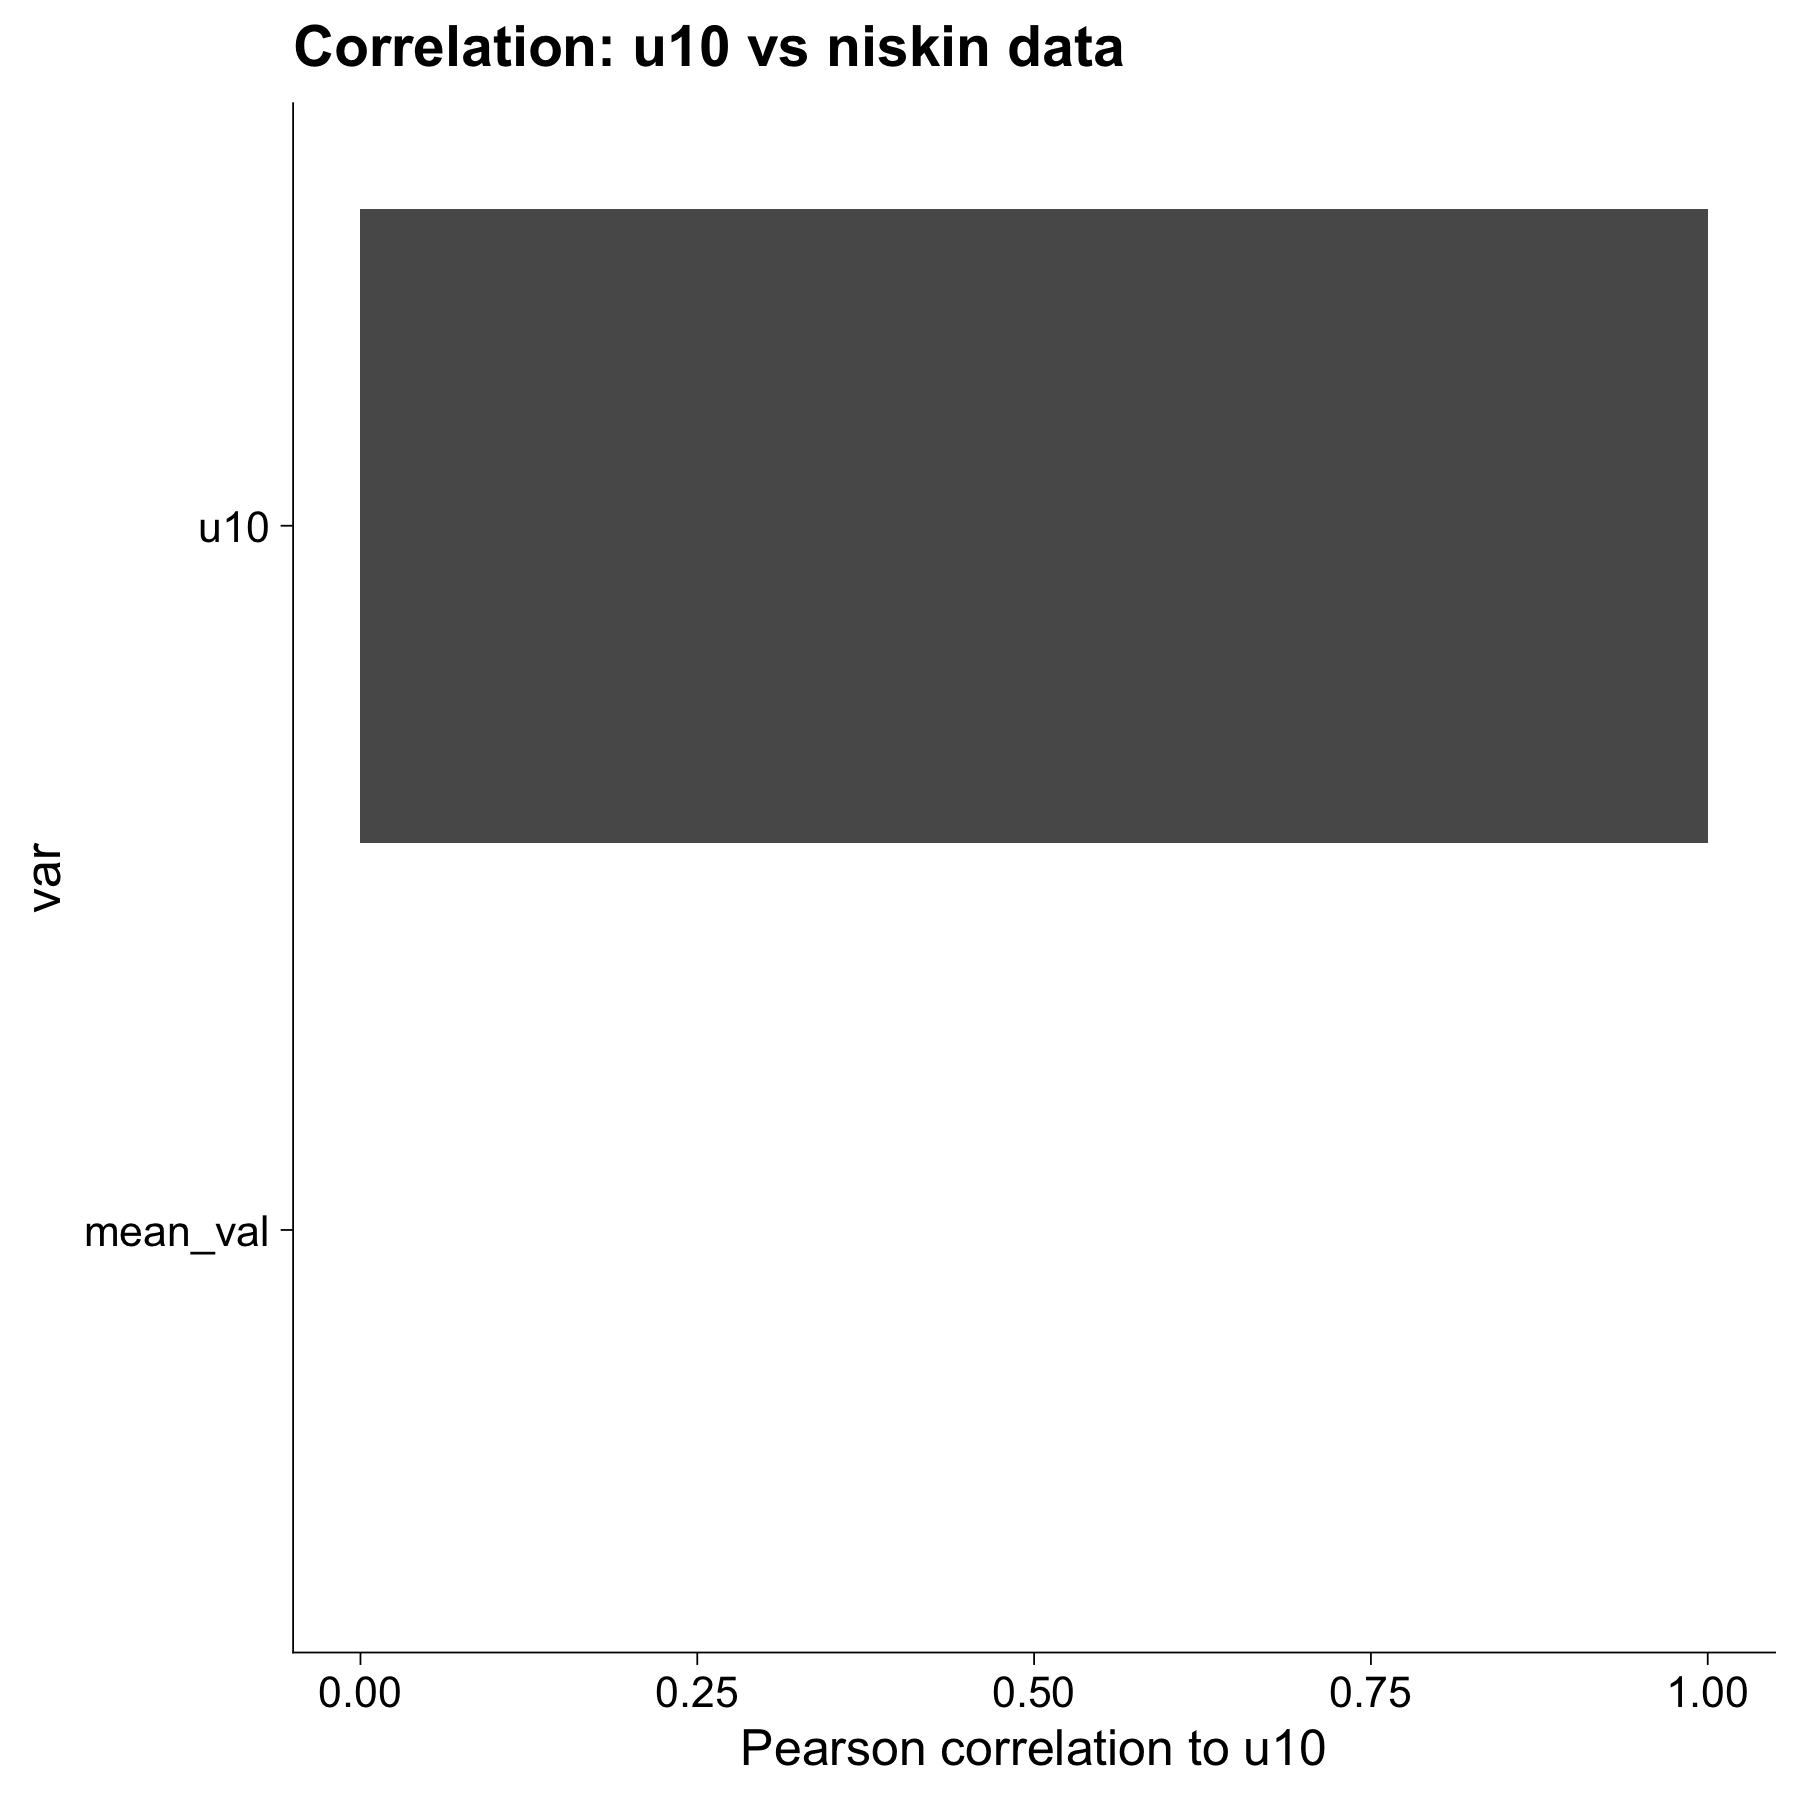

In [329]:
options(repr.plot.width=15, repr.plot.height=15)

ggplot(data=blobsVSu10_df, aes(x=var, y=correlation)) + 
    geom_bar(stat="identity") + ylab("Pearson correlation to u10") +
    theme_cowplot(font_size=30) + coord_flip() + ggtitle("Correlation: u10 vs niskin data")

# save code: